### Discrete Sine + Delta correlation

Bandpass a delta peak, and try to correlate it with an appropriate sine wave.
\
Show that we can lift the degeneracy in the correlations (within a window).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as ft
import scipy.signal as signal

# monkey patch correlation_lags into signal if it does not exist
if not hasattr(signal, 'correlation_lags'):
    def correlation_lags(in1_len, in2_len, mode='full'):
        r"""
        Calculates the lag / displacement indices array for 1D cross-correlation.
        Parameters
        ----------
        in1_size : int
            First input size.
        in2_size : int
            Second input size.
        mode : str {'full', 'valid', 'same'}, optional
            A string indicating the size of the output.
            See the documentation `correlate` for more information.
        See Also
        --------
        correlate : Compute the N-dimensional cross-correlation.
        Returns
        -------
        lags : array
            Returns an array containing cross-correlation lag/displacement indices.
            Indices can be indexed with the np.argmax of the correlation to return
            the lag/displacement.
        Notes
        -----
        Cross-correlation for continuous functions :math:`f` and :math:`g` is
        defined as:
        .. math::
            \left ( f\star g \right )\left ( \tau \right )
            \triangleq \int_{t_0}^{t_0 +T}
            \overline{f\left ( t \right )}g\left ( t+\tau \right )dt
        Where :math:`\tau` is defined as the displacement, also known as the lag.
        Cross correlation for discrete functions :math:`f` and :math:`g` is
        defined as:
        .. math::
            \left ( f\star g \right )\left [ n \right ]
            \triangleq \sum_{-\infty}^{\infty}
            \overline{f\left [ m \right ]}g\left [ m+n \right ]
        Where :math:`n` is the lag.
        Examples
        --------
        Cross-correlation of a signal with its time-delayed self.
        >>> from scipy import signal
        >>> from numpy.random import default_rng
        >>> rng = default_rng()
        >>> x = rng.standard_normal(1000)
        >>> y = np.concatenate([rng.standard_normal(100), x])
        >>> correlation = signal.correlate(x, y, mode="full")
        >>> lags = signal.correlation_lags(x.size, y.size, mode="full")
        >>> lag = lags[np.argmax(correlation)]
        """

        # calculate lag ranges in different modes of operation
        if mode == "full":
            # the output is the full discrete linear convolution
            # of the inputs. (Default)
            lags = np.arange(-in2_len + 1, in1_len)
        elif mode == "same":
            # the output is the same size as `in1`, centered
            # with respect to the 'full' output.
            # calculate the full output
            lags = np.arange(-in2_len + 1, in1_len)
            # determine the midpoint in the full output
            mid = lags.size // 2
            # determine lag_bound to be used with respect
            # to the midpoint
            lag_bound = in1_len // 2
            # calculate lag ranges for even and odd scenarios
            if in1_len % 2 == 0:
                lags = lags[(mid-lag_bound):(mid+lag_bound)]
            else:
                lags = lags[(mid-lag_bound):(mid+lag_bound)+1]
        elif mode == "valid":
            # the output consists only of those elements that do not
            # rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
            # must be at least as large as the other in every dimension.

            # the lag_bound will be either negative or positive
            # this let's us infer how to present the lag range
            lag_bound = in1_len - in2_len
            if lag_bound >= 0:
                lags = np.arange(lag_bound + 1)
            else:
                lags = np.arange(lag_bound, 1)
        return lags

    signal.correlation_lags = correlation_lags

In [2]:
def plot_spectrum( ax, spectrum, freqs, plot_complex=False, plot_power=False, plot_amplitude=None):
    """ Plot a signal's spectrum on an Axis object"""
    plot_amplitude = plot_amplitude or (not plot_power and not plot_complex)
    alpha = 1
    
    ax.set_title("Spectrum")
    ax.set_xlabel("f (Hz)")
    ylabel = ""
    if plot_amplitude or plot_complex:
        ylabel = "Amplitude"
    if plot_power:
        if ylabel:
            ylabel += "|"
        ylabel += "Power"
    ax.set_ylabel(ylabel)

    if plot_complex:
        alpha = 0.5
        ax.plot(freqs, np.real(spectrum), '.-', label='Real', alpha=alpha)
        ax.plot(freqs, np.imag(spectrum), '.-', label='Imag', alpha=alpha)

    if plot_power:
        ax.plot(freqs, np.abs(spectrum)**2, '.-', label='Power', alpha=alpha)
    
    if plot_amplitude:
        ax.plot(freqs, np.abs(spectrum), '.-', label='Abs', alpha=alpha)

    ax.legend()

    return ax

def fft_bandpass(signal, band, samplerate):
    """
    Simple bandpassing function employing a FFT.

    Parameters
    ----------
    signal : arraylike
    band : tuple(low, high)
        Frequencies for bandpassing
    samplerate : float
    """
    signal = np.asarray(signal)

    fft = ft.rfft(signal)
    freqs = ft.rfftfreq(signal.size, 1/samplerate)
    fft[(freqs < band[0]) | (freqs > band[1])] = 0
    
    return ft.irfft(fft, signal.size), (fft, freqs)

def deltapeak(timelength=1e3, samplerate=1, offset=None, peaklength=1):
    N_samples = int(timelength * samplerate)
    if offset is None:
        offset = (np.random.random()*N_samples).astype(int) % N_samples
    
    position = (offset + np.arange(0, peaklength)).astype(int) % N_samples
    
    signal = np.zeros(N_samples)
    signal[position] = 1
    
    return signal, position

def sin_delay(f, t, t_delay=0, phase=0):
    return np.cos(2*np.pi*f * (t - t_delay) + phase)

## Generate a delta peak and bandpass it

In [3]:
# Generate a delta peak and bandpass it
samplerate = 500 # MHz
band = (30, 80) # MHz

us = 1e3 # ns
ns = 1/us # us

## Delta peak properties
imp_timelength = 50 * ns# ns
imp_peaklength = 1
imp_time = np.arange(0, imp_timelength, 1/samplerate)
imp_offset = [1400]

orig_imp, imp_offset = deltapeak(imp_timelength, samplerate, offset=imp_offset, peaklength=imp_peaklength)

## Bandpass it
imp, (fft, fft_freqs) = fft_bandpass(orig_imp, band, samplerate)
imp /= np.max(imp)

#
print("Size: {}; Offset: {}; PeakLength: {}".format(orig_imp.size, imp_offset[0], len(imp_offset)))

Size: 25; Offset: 0; PeakLength: 1


<ipython-input-4-5b3a8514ce9c>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


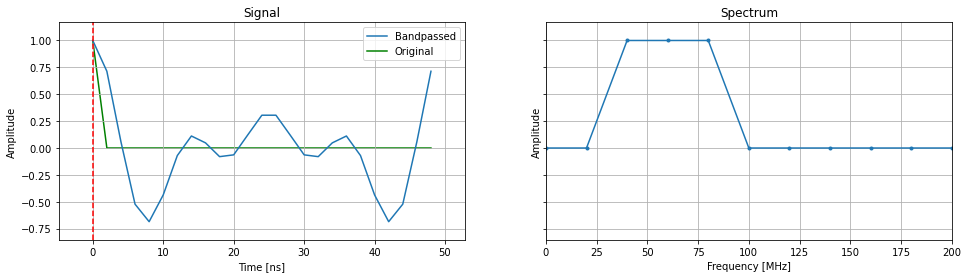

In [4]:
# Plot timedomain and frequency domain of the bandpassed signal
fig, (ax2, ax1) = plt.subplots(1,2, figsize=(16,4),sharey=True)
## Spectrum
plot_spectrum(ax1, fft, fft_freqs)
ax1.set_xlabel("Frequency [MHz]")
ax1.grid(True)
ax1.margins(0.1, 0.1)
ax1.get_legend().remove()
ax1.set_xlim(0, 200)

## Signal
ax2.set_title("Signal")
ax2.margins(0.1, 0.1)
ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Amplitude')
ax2.grid(True)
ax2.plot(imp_time/ns, imp, label='Bandpassed')
ax2.plot(imp_time/ns, orig_imp, label='Original', zorder=-1, color='g')
ax2.axvline(imp_time[imp_offset[0]]/ns, color='r', ls='--')
ax2.legend()

fig.show()

In [5]:
### correlation
def correlation_and_lag(sig1, sig2, mode="same", normalise=False):
    corr = signal.correlate(sig1, sig2, mode=mode)
    if normalise:
        corr /= np.max(corr)

    lags = signal.correlation_lags(sig1.size, sig2.size, mode=mode)
    
    return corr, lags

def find_best_lag(sig1, sig2, fix_one_short=False, fix_positive=False, **corr_kwargs):
    corr, lags = correlation_and_lag(sig1, sig2, **corr_kwargs)
    
    lag = lags[np.argmax(corr)]
    
    if fix_one_short:
        # for some reason it is always one short
        if lag > 0:
            lag += 1
        elif lag < 0:
            lag -= 1

    # turn negative lag into positive
    if fix_positive and lag < 0:
        print("negative lag")
        lag += len(sig2)
    
    return lag, (corr, lags)


def find_beacon_phase_delay(samplerate, f_beacon, reference_beacon, delayed_beacon, **lag_kwargs):
    """
    Return phase delay of `beacon` with respect to `reference_beacon`.
    Note that the returned value can be off by a multiple of $2\pi$.
    
    Parameters
    ==========
    samplerate : float
        Samplerate of both reference_beacon and delayed_beacon
    f_beacon : float
        Frequency of the beacons
    reference_beacon : ndarray
        The beacon to use as a reference
    beacon : ndarray
        The beacon to find the delay for
    """
    
    calc_lag, _ = find_best_lag(reference_beacon, delayed_beacon, **lag_kwargs)
    
    return 2*np.pi* f_beacon * calc_lag /samplerate 
    
    

### Correlate a sinusoid with the bandpassed delta peak

In [6]:
###########################################
# Correlate a sinusoid

## define sinusoid properties

# in-band or out-of-band
if True:
    f_sine = 50 # MHz
    corr_sig_timelength = 1/f_sine # us
else:
    f_sine = 20 # MHz
    corr_sig_timelength = 1/f_sine # us
    
## define general correlation signal properties
corr_sig_samplerate = samplerate # MHz
corr_sig_samplelength = corr_sig_timelength * corr_sig_samplerate
corr_time = np.arange(0, corr_sig_timelength, 1/corr_sig_samplerate)

corr_sig = sin_delay(f_sine, corr_time, t_delay=0, phase=-1/2*np.pi)

## define the signals
if not True:
    sig1 = imp
    sig1_time = imp_time
    sig1_offset = imp_time[imp_offset[0]]
else:
    sig1_offset = 6*ns # us
    sig1 = sin_delay(f_sine, corr_time, t_delay=sig1_offset)
    sig1_time = corr_time


## correlate it and find the best correlation
calc_lag, (corr, lags) = find_best_lag(sig1, corr_sig, mode='full', fix_one_short=False)

calc_lag += 1

#####
lag_times = lags / corr_sig_samplerate # us
calc_lag_time = (calc_lag) / corr_sig_samplerate # us



#(calc_lag_time - 1/corr_sig_samplerate)
#((calc_lag_time*corr_sig_samplerate - 1) - (calc_lag_time - 1)) /samplerate




#calc_lag_time = ((len(corr)-1)/2 - corr.argmax())/corr_sig_samplerate

calc_phase_lag = 2*np.pi*f_sine*calc_lag_time

print("Known offset [ns]:", sig1_offset/ns)
print("Known phase [ns]:", 2*np.pi*f_sine*sig1_offset)
print("Expected lag:", sig1_offset*corr_sig_samplerate)
print("Lag time multiplier [ns]:", 1/corr_sig_samplerate/ns)
print("Calc Lag:", calc_lag)
print("Calc Lag time [ns]:", calc_lag_time/ns)
print("Phase lag:", calc_phase_lag)

Known offset [ns]: 6.0
Known phase [ns]: 1.884955592153876
Expected lag: 3.0
Lag time multiplier [ns]: 2.0
Calc Lag: 1
Calc Lag time [ns]: 2.0
Phase lag: 0.6283185307179586


2.0


<ipython-input-7-42b7d03bc798>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


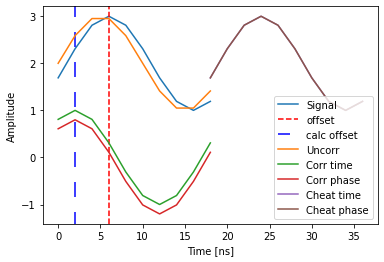

In [7]:
#####
# Plot signal
#####

fig, ax = plt.subplots()
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Amplitude")


ax.plot(sig1_time/ns, sig1+2, label='Signal')
ax.axvline(sig1_offset/ns, color='r', ls='--', label='offset')


ax.axvline(calc_lag_time/ns, color='b', ls=(2, (10, 10)), label='calc offset')
ax.plot(corr_time/ns, corr_sig+2, label="Uncorr")
ax.plot(sig1_time/ns, sin_delay(f_sine, sig1_time, t_delay=calc_lag_time), label="Corr time")
ax.plot(sig1_time/ns, sin_delay(f_sine, sig1_time, phase=-1*calc_phase_lag)-0.2, label="Corr phase")

# debugging
if True:
    ax.plot(corr_time[-1]/ns + corr_time/ns, sin_delay(f_sine, corr_time, t_delay=sig1_offset)+2, label="Cheat time")
    ax.plot(corr_time[-1]/ns + corr_time/ns, sin_delay(f_sine, corr_time, phase=-2*np.pi*sig1_offset*f_sine)+2, label="Cheat phase")
    
    
ax.legend()
fig.show();
print((sig1_offset - calc_lag_time)*samplerate)

<ipython-input-8-b80dbc5f3c93>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


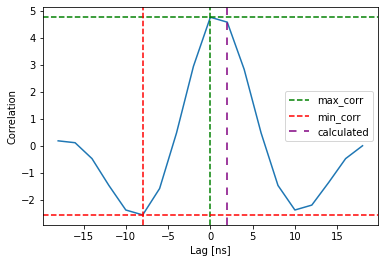

In [8]:
#####
# Plot Correlation
#####
max_corr_id = np.argmax(corr)
min_corr_id = np.argmin(corr)
fig, ax = plt.subplots()
ax.set_xlabel("Lag [ns]")
ax.set_ylabel("Correlation")
ax.plot(lag_times/ns, corr)

ax.plot()

ax.axvline(lag_times[max_corr_id]/ns, ls='--',color='g', label="max_corr")
ax.axhline(corr[max_corr_id], ls='--', color='g')
ax.axvline(lag_times[min_corr_id]/ns, ls='--', color='r', label='min_corr')
ax.axhline(corr[min_corr_id], ls='--', color='r')

ax.axvline(calc_lag_time/ns, ls=(0, (5, 5)), color='purple', label='calculated')
ax.legend()
fig.show();